In [1]:
#import pyarrow.feather as feather
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set(color_codes=True)
from numpy.random import seed
#from scipy.io import netcdf
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [2]:
# it is better for visualisation if the columns date type (not int or str)
# when save df to csv, if the column names are date, they are saved as str
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        try:
            new_columns.append(pd.to_datetime(col).date())
        except: new_columns.append(col)
    return new_columns

In [3]:
###########################################################################################################

In [ ]:
# pick sample6 , the clearly visualized outliers

proj = ["BB_25496023", "BB_25496025", "BB_25510027", "BB_26471092",
        "BB_27410202", "BB_27450129", "BB_27471020", "BB_28370023","RP_2375255000"]

ts = grouped_t_s.loc[proj]
temp = ave_temp.loc[proj]
prec = cum_prec.loc[proj]
#ts.to_csv(f"dataset/modeling/sample6/ts.csv")
#temp.to_csv(f"dataset/modeling/sample6/temp.csv")
#prec.to_csv(f"dataset/modeling/sample6/prec.csv")

In [4]:
# import sample6
grouped_t_s= pd.read_csv(f"dataset/modeling/sample6/ts.csv").set_index("proj_id")
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
ave_temp= pd.read_csv(f"dataset/modeling/sample6/temp.csv").set_index("proj_id")
ave_temp.columns = convert_col_to_date(ave_temp.columns)
cum_prec= pd.read_csv(f"dataset/modeling/sample6/prec.csv").set_index("proj_id")
cum_prec.columns = convert_col_to_date(cum_prec.columns)
print(grouped_t_s.shape)
print(ave_temp.shape)
print(cum_prec.shape)

(9, 6546)
(9, 6546)
(9, 6546)


In [5]:
grouped_t_s

,length,freq,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
BB_25496023,4802,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.75,36.74,36.74,36.74,36.77,36.78,36.79,36.79,36.82,36.80
BB_25496025,4676,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.77,36.76,36.77,36.76,36.79,36.80,36.81,36.81,36.84,36.82
BB_25510027,1279,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,13.61,NaN,13.61,NaN,NaN,13.63,NaN,13.65,NaN
BB_26471092,4240,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_27410202,854,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.38,...,NaN,69.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_27450129,864,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.37,...,NaN,55.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BB_27471020,3815,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,72.37,72.36,72.37,72.36,72.37,72.37,72.37,72.37,72.37,72.36
BB_28370023,4058,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RP_2375255000,476,14,NaN,98.54,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# func

In [7]:
# create df for a t s (one row in grouped_t_s df)
def create_one_ts_df(row):
    bgr = row.name
    idx = row.dropna().index[2:]
    ts = row[idx]
    temp = ave_temp[idx].loc[bgr]
    prec = cum_prec[idx].loc[bgr]
    df = pd.DataFrame({"ts":ts,"temp": temp,"prec":prec, })
    return df


ts length:4058.0, freq: 1.0,lag: 200.0 days
(4058, 3)


Text(0.5, 1.0, 'prec')

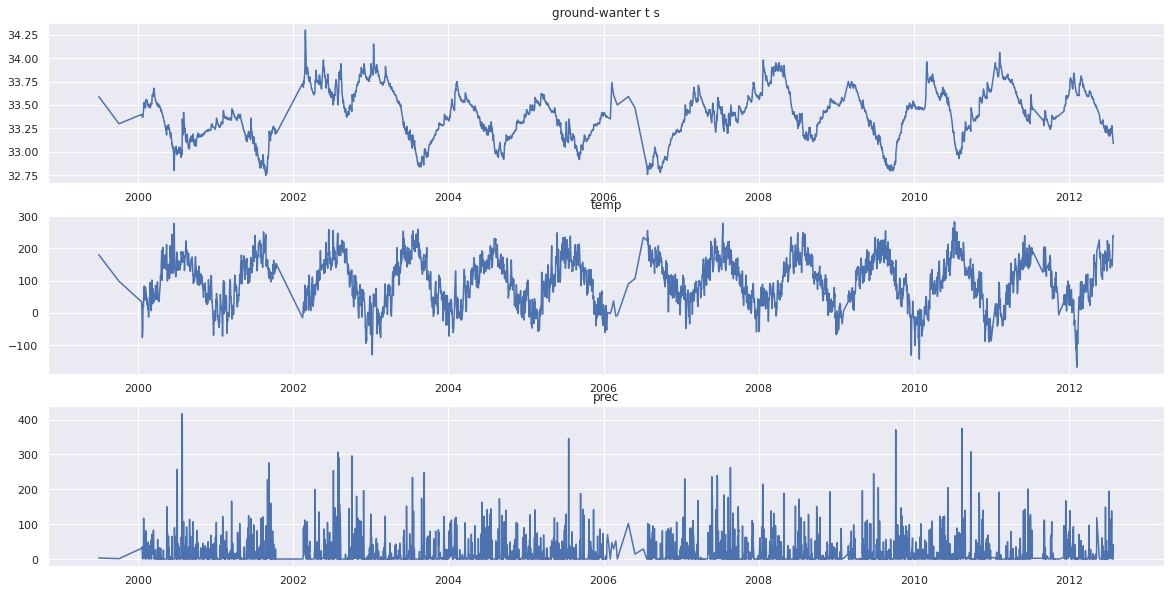

In [57]:
# apply the func RP_2375255000, BB_27410202
#ts1 = grouped_t_s.iloc[3] 
ts1 = grouped_t_s.loc["BB_28370023"]
lag = int(200/ts1[1]) # lag of 200 days
print(f"ts length:{ts1[0]}, freq: {ts1[1]},lag: {lag*ts1[1]} days")
df = create_one_ts_df(ts1)
print(df.shape)
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 0,5000
axs[0].plot(df["ts"][a:b])
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["prec"][a:b])
axs[2].set_title('prec')

# pick up one ts with its corresponding temp and prec, and plot them all

ts length:3815.0, freq: 1.0,lag: 200.0 days
(3784, 3)


Text(0.5, 1.0, 'prec')

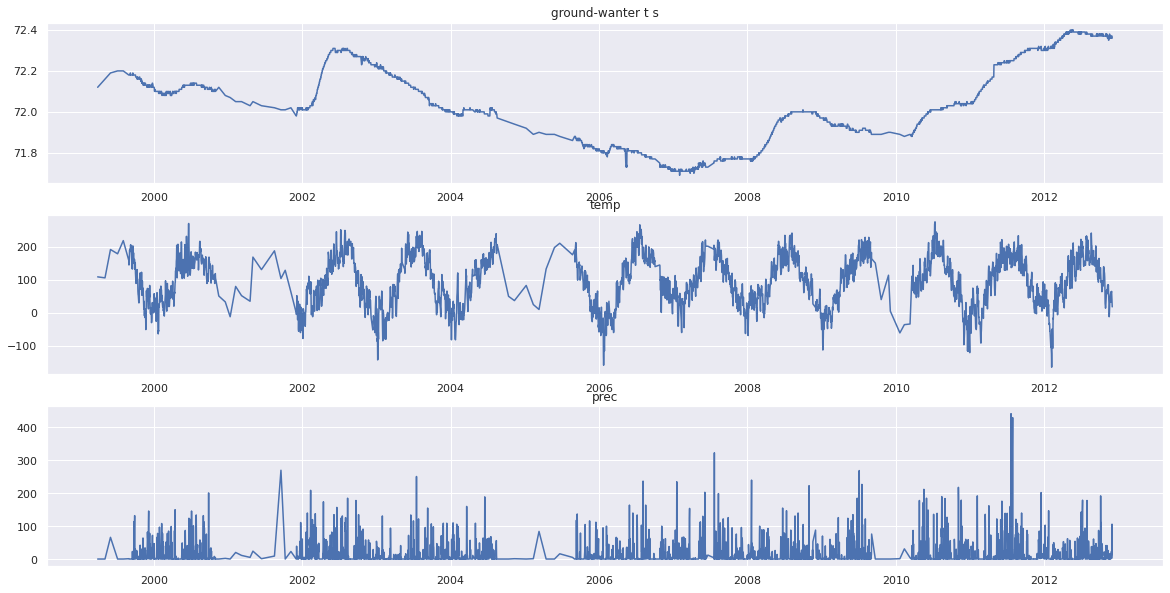

In [58]:
# apply the func RP_2375255000, BB_27410202, BB_28370023
#ts1 = grouped_t_s.iloc[3] 
ts1 = grouped_t_s.loc["BB_27471020"]
lag = int(200/ts1[1]) # lag of 200 days
print(f"ts length:{ts1[0]}, freq: {ts1[1]},lag: {lag*ts1[1]} days")
df = create_one_ts_df(ts1)
print(df.shape)
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 0,5000
axs[0].plot(df["ts"][a:b])
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["prec"][a:b])
axs[2].set_title('prec')

In [59]:
def series_to_supervised(data, n_in=lag, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
idx = df.index[lag:]
df =series_to_supervised(df.values)
df.index=idx
df

,var1(t-200),var2(t-200),var3(t-200),var1(t-199),var2(t-199),var3(t-199),var1(t-198),var2(t-198),var3(t-198),var1(t-197),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
2000-03-13,72.12,109.0,0.0,72.16,106.0,0.0,72.19,192.0,66.0,72.20,...,32.0,72.09,42.0,28.0,72.09,19.0,0.0,72.09,60.0,14.0
2000-03-14,72.16,106.0,0.0,72.19,192.0,66.0,72.20,179.0,0.0,72.20,...,28.0,72.09,19.0,0.0,72.09,60.0,14.0,72.10,69.0,85.0
2000-03-15,72.19,192.0,66.0,72.20,179.0,0.0,72.20,219.0,0.0,72.18,...,0.0,72.09,60.0,14.0,72.10,69.0,85.0,72.09,29.0,8.0
2000-03-16,72.20,179.0,0.0,72.20,219.0,0.0,72.18,159.0,1.0,72.18,...,14.0,72.10,69.0,85.0,72.09,29.0,8.0,72.09,26.0,39.0
2000-03-17,72.20,219.0,0.0,72.18,159.0,1.0,72.18,145.0,1.0,72.18,...,85.0,72.09,29.0,8.0,72.09,26.0,39.0,72.09,19.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-26,72.39,190.0,29.0,72.39,190.0,17.0,72.39,95.0,1.0,72.39,...,5.0,72.36,48.0,12.0,72.37,64.0,5.0,72.37,62.0,23.0
2012-11-27,72.39,190.0,17.0,72.39,95.0,1.0,72.39,76.0,0.0,72.40,...,12.0,72.37,64.0,5.0,72.37,62.0,23.0,72.37,65.0,2.0
2012-11-28,72.39,95.0,1.0,72.39,76.0,0.0,72.40,102.0,0.0,72.40,...,5.0,72.37,62.0,23.0,72.37,65.0,2.0,72.37,50.0,10.0
2012-11-29,72.39,76.0,0.0,72.40,102.0,0.0,72.40,122.0,0.0,72.39,...,23.0,72.37,65.0,2.0,72.37,50.0,10.0,72.37,40.0,106.0


# Autoencoder LSTM model: 

In [65]:

# split df into train 80% and test 20%, 
n_train = int(len(df)*0.8)
train = df[:n_train]
test = df[n_train:]

# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)



Training data shape: (2867, 1, 603)
Test data shape: (717, 1, 603)


In [66]:
# define the autoencoder network model
def autoencoder_model(X):
    # define the input vector
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    # compress the input data (encoder)
    L1 = LSTM(16, activation='relu', return_sequences=True,kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    # distribute the compressed representational vector across the time steps of the decoder
    L3 = RepeatVector(X.shape[1])(L2)
    # decompress the  data (decoder)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    # reconstructed input data
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 603)]          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 16)             39680     
_________________________________________________________________
lstm_9 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 603)            1025

In [67]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history


Epoch 1/100
273/273 [==============================] - 10s 11ms/step - loss: 0.2449 - val_loss: 0.0835
Epoch 2/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0764 - val_loss: 0.0803
Epoch 3/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0697 - val_loss: 0.0782
Epoch 4/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0686 - val_loss: 0.0767
Epoch 5/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0682 - val_loss: 0.0777
Epoch 6/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0671 - val_loss: 0.0731
Epoch 7/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0675 - val_loss: 0.0738
Epoch 8/100
273/273 [==============================] - 2s 9ms/step - loss: 0.0673 - val_loss: 0.0751
Epoch 9/100
273/273 [==============================] - 3s 10ms/step - loss: 0.0667 - val_loss: 0.0749
Epoch 10/100
273/273 [==============================] - 2s 9ms/step - loss: 0.0651 - val

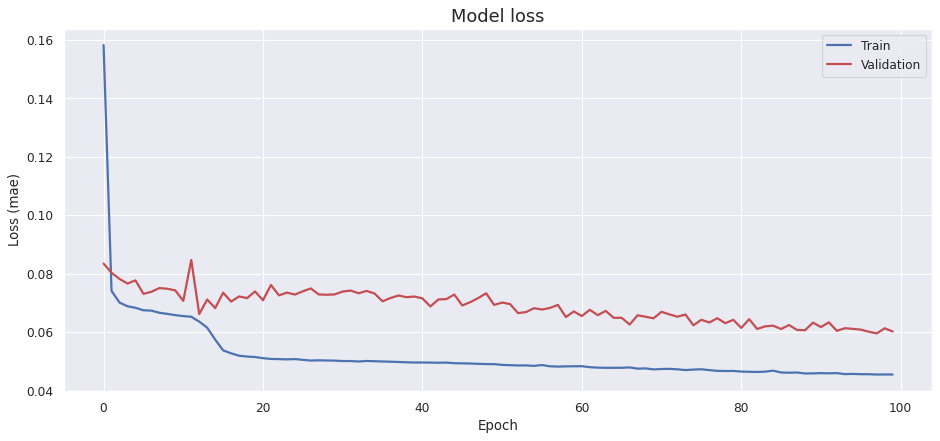

In [68]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [14]:
###################################################################################

In [98]:
# plot the loss distribution of the training set
# reconstruct the training dataset (predicting)
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

# compute the loss (error between the predcted training and the original training)
scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])


(0.0, 0.2)

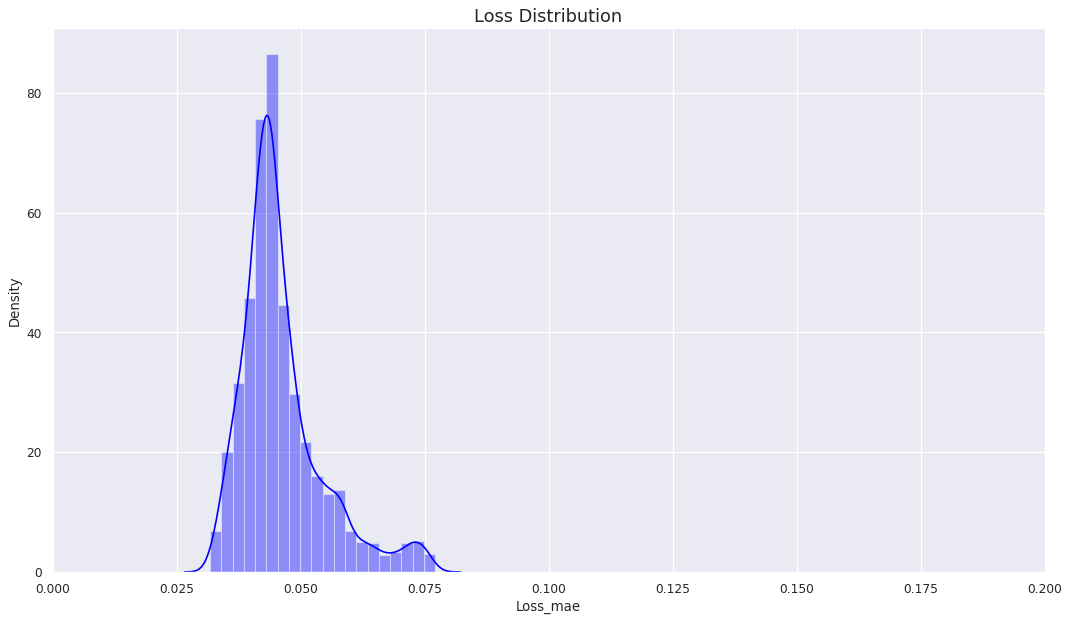

In [90]:
# the ave loss for all features
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.2])

(0.0, 0.9)

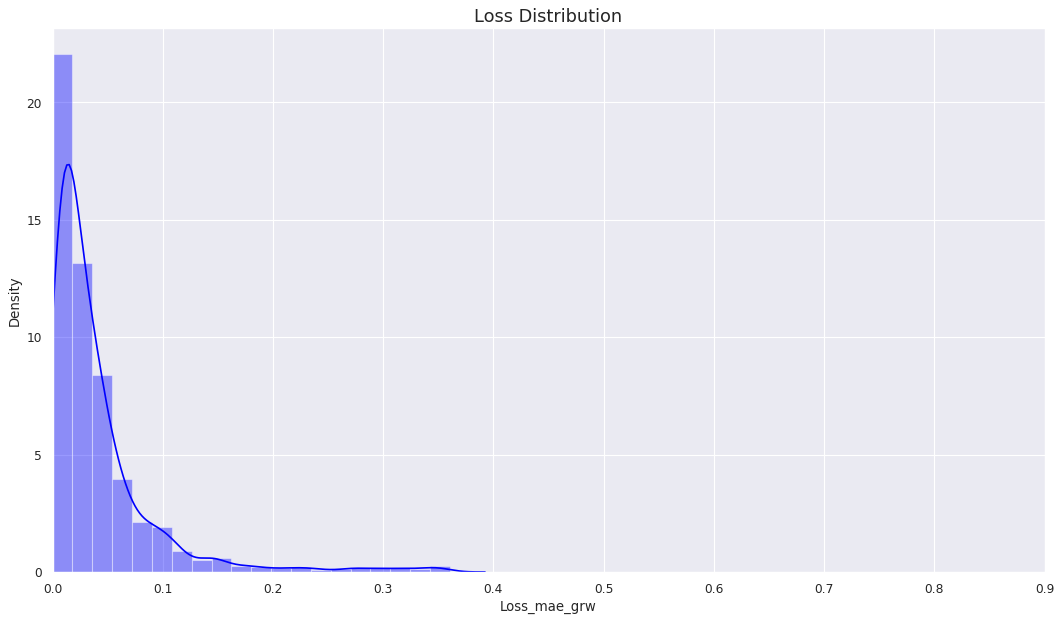

In [99]:
# the loss for current groundwater level only 
scored['Loss_mae_grw'] = np.abs(X_pred["var1(t)"] - Xtrain[:,-3])
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae_grw'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.9])

In [ ]:
###################################################################################

In [92]:
# compute a threshold -> four std from the mean of the loss
print( f"max loss: {scored['Loss_mae'].max()}")
thre = np.mean(scored,axis=0)[0]+ 3*np.std(scored,axis=0)[0]
thre

max loss: 0.0771250135766147


0.07135218319300723

In [101]:
# compute a threshold -> four std from the mean of the loss
print( f"max loss: {scored['Loss_mae_grw'].max()}")
thre_g = np.mean(scored,axis=0)[0]+ 5*np.std(scored,axis=0)[0]
thre_g

max loss: 0.3605281979806989


0.3018698877992494

## the outliers are the points that have loss higher than the threshold
## 

In [94]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index =test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = thre# 0.175
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
#scored.head()

# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = thre
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [95]:
print(scored[scored["Anomaly"]==True].shape)
scored[scored["Anomaly"]==True][:10]

(441, 3)


,Loss_mae,Threshold,Anomaly
2002-04-19,0.071619,0.071352,True
2002-04-20,0.072394,0.071352,True
2002-04-21,0.072477,0.071352,True
2002-04-22,0.072493,0.071352,True
2002-04-23,0.073317,0.071352,True
2002-04-24,0.073522,0.071352,True
2002-04-25,0.074255,0.071352,True
2002-04-26,0.074490,0.071352,True
2002-04-27,0.075372,0.071352,True
2002-04-28,0.075682,0.071352,True


In [45]:
print(scored[scored["Anomaly"]==True].shape)
anomaly = scored[scored["Anomaly"]==True].index
anomaly

(29, 3)


Index([2002-04-22, 2008-04-01, 2008-04-08, 2008-04-15, 2008-04-22, 2011-03-08,
       2011-03-15, 2011-03-22, 2011-04-01, 2011-04-08, 2011-04-15, 2011-04-22,
       2011-05-01, 2011-10-22, 2011-11-01, 2011-11-08, 2011-11-15, 2011-11-22,
       2011-12-01, 2011-12-08, 2011-12-15, 2011-12-22, 2012-01-01, 2012-01-08,
       2012-04-08, 2012-04-15, 2012-04-22, 2012-05-01, 2012-05-08],
      dtype='object')

<AxesSubplot:>

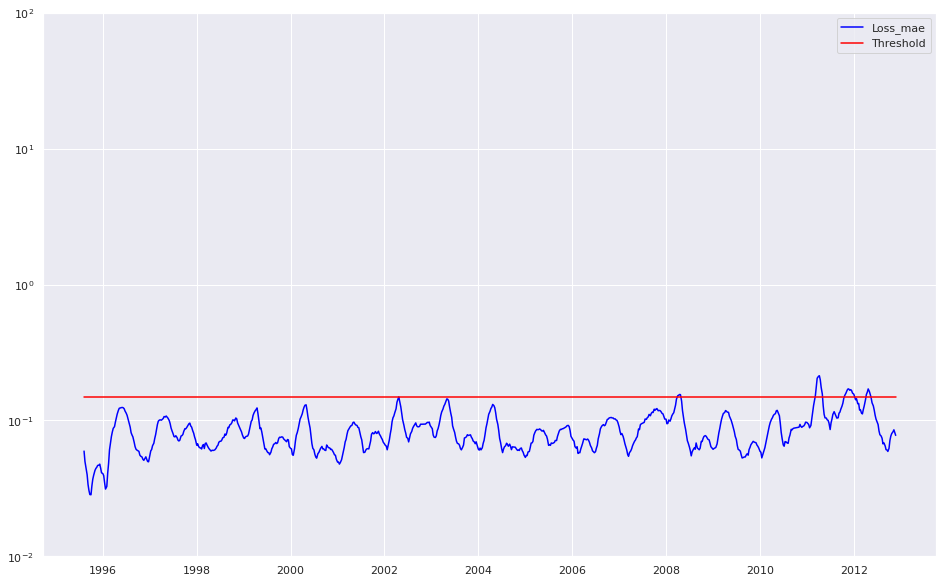

In [46]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,10), ylim=[1e-2,1e2], color=['blue','red'])


# with lag of 100 days, threshold 3 std of the mean of loss

Text(0.5, 1.0, 'prec')

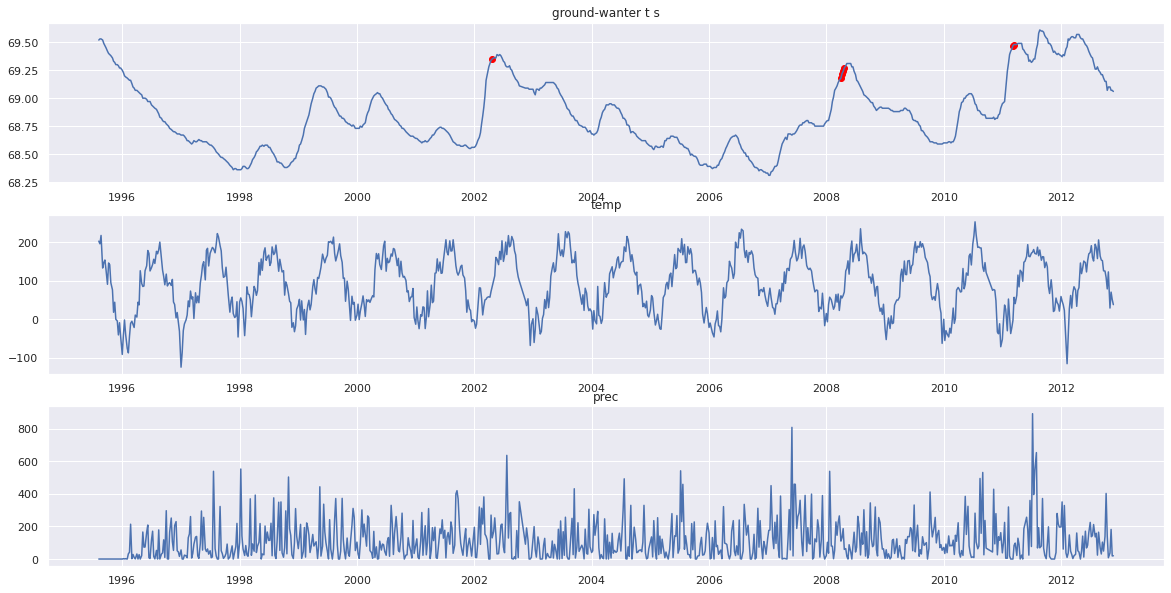

In [48]:
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 220,320
a,b = 0,1000
axs[0].plot(df["var1(t)"][a:b])
axs[0].scatter(anomaly[:7], df["var1(t)"][anomaly][:7], color="red") #df["var1(t)"]
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["var2(t)"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["var3(t)"][a:b])
axs[2].set_title('prec')

In [63]:
#############################################################################

In [102]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index =test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])

scored['Loss_mae_grw'] = np.abs(X_pred["var1(t)"] - Xtest[:,-3])
scored['Threshold_g'] = thre_g
scored['Anomaly_g'] = scored['Loss_mae_grw'] > scored['Threshold_g']
#scored.head()

# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae_grw'] = np.abs(X_pred_train["var1(t)"] - Xtrain[:,-3])

scored_train['Threshold_g'] = thre_g
scored_train['Anomaly_g'] = scored_train['Loss_mae_grw'] > scored_train['Threshold_g']
scored = pd.concat([scored_train, scored])

In [103]:
print(scored[scored["Anomaly_g"]==True].shape)
scored[scored["Anomaly_g"]==True][:10]

(66, 3)


,Loss_mae_grw,Threshold_g,Anomaly_g
2002-04-11,0.302890,0.30187,True
2002-04-14,0.303364,0.30187,True
2002-04-15,0.324835,0.30187,True
2002-04-16,0.324447,0.30187,True
2002-04-17,0.320044,0.30187,True
2002-04-18,0.318588,0.30187,True
2002-04-19,0.336030,0.30187,True
2002-04-20,0.337864,0.30187,True
2002-04-21,0.333373,0.30187,True
2002-04-22,0.347084,0.30187,True


In [104]:
print(scored[scored["Anomaly_g"]==True].shape)
anomaly = scored[scored["Anomaly_g"]==True].index
anomaly

(66, 3)


Index([2002-04-11, 2002-04-14, 2002-04-15, 2002-04-16, 2002-04-17, 2002-04-18,
       2002-04-19, 2002-04-20, 2002-04-21, 2002-04-22, 2002-04-23, 2002-04-24,
       2002-04-25, 2002-04-26, 2002-04-27, 2002-04-28, 2002-04-29, 2002-04-30,
       2002-05-01, 2002-05-02, 2002-05-03, 2002-05-04, 2002-05-05, 2002-05-06,
       2002-05-07, 2002-05-08, 2002-05-09, 2002-05-10, 2002-05-11, 2011-04-28,
       2011-04-29, 2011-04-30, 2011-05-01, 2011-05-02, 2011-05-03, 2011-05-04,
       2011-05-05, 2011-05-06, 2011-05-07, 2011-05-08, 2011-05-09, 2011-05-10,
       2011-05-11, 2011-05-12, 2011-05-13, 2011-05-14, 2011-05-15, 2011-05-16,
       2011-05-17, 2011-05-18, 2011-05-19, 2011-05-20, 2011-05-21, 2011-05-22,
       2011-05-23, 2011-05-24, 2011-05-25, 2011-05-26, 2011-05-27, 2011-08-06,
       2011-08-07, 2011-08-08, 2011-08-09, 2011-08-10, 2011-08-11, 2011-08-12],
      dtype='object')

<AxesSubplot:>

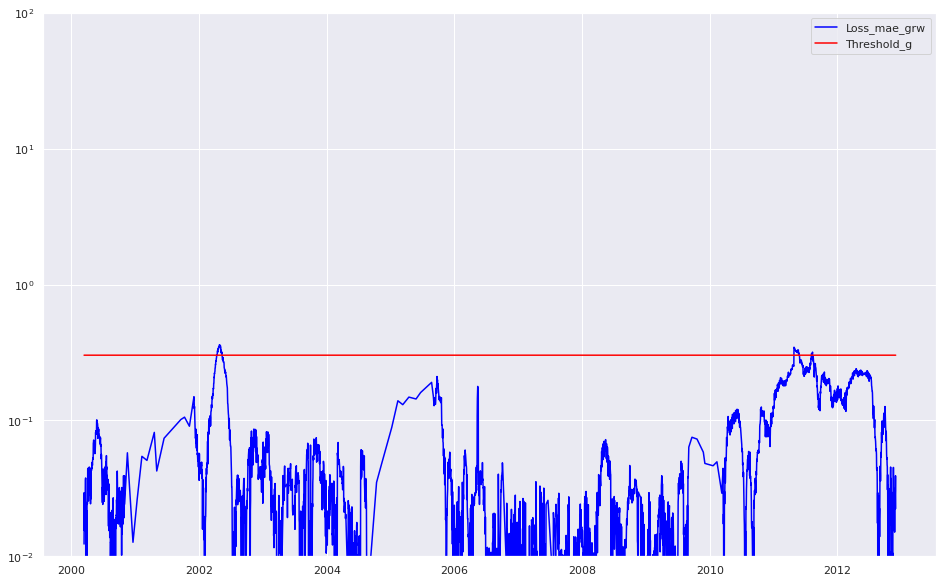

In [105]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,10), ylim=[1e-2,1e2], color=['blue','red'])


Text(0.5, 1.0, 'prec')

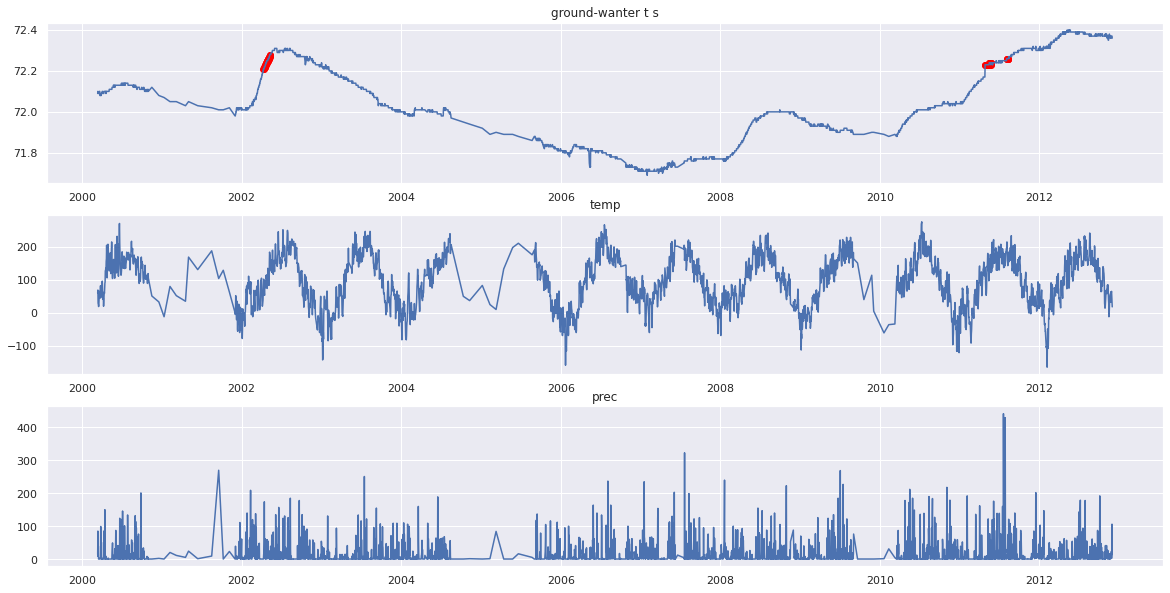

In [106]:
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
#a,b = 290,350
a,b = 0,4000
axs[0].plot(df["var1(t)"][a:b])
axs[0].scatter(anomaly[:], df["var1(t)"][anomaly][:], color="red") #df["var1(t)"]
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["var2(t)"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["var3(t)"][a:b])
axs[2].set_title('prec')